# Подсчёты $\lambda$

In [1]:
from analys.energy import Staticstics
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class atom():
    '''
    Параметры конкретного атома
    '''
    def __init__(self, 
                 data,
                 molecule = 0, 
                 atom = 0,
                 **kwargs):
        
        self.molecule = molecule
        self.atom = atom
        self.coord = self.get_matrix(data, 0)
        self.vel = self.get_matrix(data, 1)
        
    def get_matrix(self, data, delta):
        ''' 
        deltadelta = 0 --- coordinates
        delta = 1 --- velocities
        molecule/atom --- numbers 0,1
        '''
        start_index = self.molecule * 12 + self.atom * 6 + delta
        
        v1 = []
        for ind in range(start_index, start_index + 6, 2):
            v1.append(data[ind])
        
        return np.array(v1)

In [3]:
class molecule():
    def __init__(self,
                 data,
                 molecule=0, 
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        '''
        > Параметры:
        >>> k - жесткость "пружины" в молекуле;
        >>> unstretched --- расстояние между атомами при релаксации;
        '''
        self.k = k
        self.unstretched = unstretched
        self.atom0 = atom(data, molecule, 0)
        self.atom1 = atom(data, molecule, 1)
        self.vel = self.center_molecular_vel()
        self.coord = self.center_molecular_coord()
        self.M = 2.
        
    def center_molecular_vel(self):
        return (self.atom0.vel + self.atom1.vel) / 2.
    
    def center_molecular_coord(self):
        return (self.atom0.coord + self.atom1.coord) / 2.

    def interatomic_distance(self):
        return np.sqrt(np.sum((self.atom0.coord - self.atom1.coord) ** 2, axis = 0))
        
    def V_in(self):
        '''
        Потенциальная энергия V = k * (r - r0)^2
        '''
        dist = self.interatomic_distance()
    
        return self.k * ((dist - self.unstretched) ** 2)
    

    def T(self, mv = 0.0):
        '''
        Кинетическая энергия молекулы T = v^2/2
        Параметры:
        >>> mv --- скорость центра масс системы,
        >>> (т.е. для подсчёта без неё)
        '''
        vel0 = self.atom0.vel - mv
        vel1 = self.atom1.vel - mv
        return  0.5  *(np.sum(vel0 ** 2, axis = 0) + np.sum(vel1 ** 2, axis = 0))
    
    def T_c(self, mv = 0.0):
        '''
        Кинетическая энергия центра масс молекулы
        '''
        return self.M * np.sum((self.vel - mv) ** 2, axis = 0) / 2.

    def T_in(self, mv = 0.0):
        '''
        Внутренняя кинетическая энергия молекулы
        '''
        # остались скорости
        v1 = self.atom0.vel - self.vel
        v2 = self.atom1.vel - self.vel
        return np.sum(v1 **2 + v2 **2, axis = 0)/2
        
    
    def Full_Energy(self, mv=0.0):
        ''' 
        полная энергия в молекуле
        '''
        return self.T(mv) + self.V_in()
    
    
    def Divided_energy(self):
        '''
        Разделим энергию на составляющие: forward, vibrational, rational 
        '''
        
        forward = self.M * np.sum(self.vel * self.vel, axis = 0) / 2.
        
        # остались скорости
        v1 = self.atom0.vel - self.vel
        v2 = self.atom1.vel - self.vel
        T_in = np.sum(v1 **2 + v2 **2, axis = 0)/2
        
        # найдём вектор между двумя атомами
        vec = self.atom1.coord - self.atom0.coord
        dist = self.interatomic_distance()
        # проецируем скорости на этот вектор 
        v1_pr = (np.sum(v1 * vec, axis=0) / dist) * (vec / dist )
        v2_pr = (np.sum(v2 * vec, axis=0) / dist) * (vec / dist)

        #колебательная энергия
        vibrational = np.sum((v1_pr * v1_pr + v2_pr * v2_pr), axis = 0) / 2.0 + self.V_in()
        
        v1_r = v1 - v1_pr
        v2_r = v2 - v2_pr
        rational = np.sum((v1_r * v1_r + v2_r * v2_r)/2.0, axis = 0) 

        return forward, rational, vibrational

In [4]:
class molecular_system():
    def __init__(self, data, 
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        
        self.m0 = molecule(data, 0, k, unstretched)
        self.m1 = molecule(data, 1, k, unstretched)
        self.vel = self.center_vel()
        self.coord = self.center_coord()
        self.M = 4.
        self.m_r = (2. * 2.)/ (2.+2.)
        self.c_r = self.relative_velocity()
        
    def center_vel(self):
        '''
        Скорость центра масс системы
        '''
        return (self.m0.vel + self.m1.vel) / 2.
    
    def center_coord(self):
        '''
        Координаты центра масс системы
        '''
        return (self.m0.coord + self.m1.coord) / 2.

    def intermolecular_distance(self):
        '''
        Расстояние между молекулами
        '''
        return np.sqrt(np.sum((self.m0.coord - self.m1.coord) ** 2, axis = 0))    

    def relative_velocity(self):
        '''c_r'''
        return self.m1.vel - self.m0.vel
    
    def relative_velocity_len(self):
        '''c_r'''
        return np.sqrt(np.sum(self.c_r ** 2, axis = 0))

    
    @staticmethod
    def dist2(ri,rj):
        ''' Расстояние между атомами '''
        return np.sum((ri - rj)**2, axis=0)

    
    def V_in(self):
        return self.m0.V_in() +  self.m1.V_in()
    
    
    def LD(self):
        '''
        Потенциал ЛД
        '''
        result = 0.0
        
        dist = self.dist2(self.m0.atom0.coord,self.m1.atom0.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom0.coord,self.m1.atom1.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom1.coord,self.m1.atom0.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom1.coord,self.m1.atom1.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
                
        return 4 * result

    def Full_Energy(self):
        '''
        Полная энергия системы
        '''
        return self.m0.Full_Energy() + self.m1.Full_Energy()  + self.LD()
    
    
    def Full_Energy_r(self):
        '''
        Полная энергия системы за вычетом Кинетической энергии движения центра масс системы
        '''
        return self.Full_Energy() - self.T_c()  #self.m0.V_in() + self.m1.V_in()  + self.LD() +self.T_r()
    
    def Full_Energy_rt(self):
        '''
        Полная энергия системы за вычетом Кинетической энергии движения центра масс системы
        и внутренней кинетической энергии молекулы
        '''
        return self.Full_Energy() - self.T_c() - self.T_in() #self.m0.V_in() + self.m1.V_in()  + self.LD() +self.T_r()

    def T_r(self):
        '''
        Кинетическая энергия отнсительнго движения
        '''
        return self.m_r * np.sum((self.c_r  ** 2), axis=0) / 2.
    
    #def T_r(self):
    #    '''
    #    Кинетическая энергия отнсительнго движения
    #    '''
    #    return self.m_r * np.sum(((self.c_r - self.vel)  ** 2), axis=0) / 2.
    
    def T_c(self):
        '''
        Кинетическая энергия центра масс системы
        '''
        return self.M * np.sum( (self.vel ** 2) , axis = 0)/ 2.

    
    def T_in(self):
        ''' 
        Внутренняя кинетическая энергия молекулы
        '''
        return self.m0.T_in() + self.m1.T_in() 
        
    def T(self):
        '''
        Полная кинетическая энергия системы
        '''
        return self.m0.T() + self.m1.T() 
    
    def Divided_energy(self):
        forward, rational, vibrational = self.m0.Divided_energy()
        forward1, rational1, vibrational1 = self.m1.Divided_energy()
        return forward + forward1, rational + rational1, vibrational + vibrational1
    
    def length_vel(self):
        return np.sqrt(np.sum(self.vel ** 2, axis = 0))

In [5]:
class calc_system():
    def __init__(self, 
                 aiming = "0.00", num = "0", PATH =  "1/out_8/",
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        
        data_init, data_end = self.get_data(aiming, num, PATH)
        self.s1 = molecular_system(data_init, k, unstretched)
        self.s2 = molecular_system(data_end, k, unstretched)
        
    @staticmethod
    def to_num(init):
        for i in range(24):
            init[i] = pd.to_numeric(init[i])        
        return init    
    
    def get_data(self, aiming, num, PATH):
        init = pd.read_csv(PATH + 'aiming_{0}/init/file_{1}.csv'.format(aiming, num), sep='\t',header=None)
        end = pd.read_csv(PATH + 'aiming_{0}/LF/file_{1}.csv'.format(aiming, num), sep='\t',header=None)

        del init[24]
        del end[24]

        init = init[~init.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
        end = end[~end.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
        init, end = self.to_num(init), self.to_num(end)
        return init, end

    def angle(self):
        return np.mean(np.sum(self.s1.vel * self.s2.vel, axis = 0)/(self.s1.length_vel() * self.s2.length_vel()))
    
    def diff_c_r(self):
        return self.s1.vel - self.s2.vel
    
    def lmbd(self):
        '''Лямбда'''
        return  np.sum(self.s1.T_r()) / np.sum(self.s1.Full_Energy_r()),\
                np.sum(self.s2.T_r()) / np.sum(self.s2.Full_Energy_r())
        
        
    def lmbd2(self):
        '''для подсчёта лямбда'''
        return  np.sum(self.s1.T_r()), np.sum(self.s1.Full_Energy_r()),\
                np.sum(self.s2.T_r()), np.sum(self.s2.Full_Energy_r())
        
    def lmbd_1(self):
        '''Лямбда без внутренней кинетической энергии'''
        return  np.mean(self.s1.T_r() / self.s1.Full_Energy_r()),\
                np.mean(self.s2.T_r() / self.s2.Full_Energy_r())
    
    def Full_Energy(self):
        return self.s1.Full_Energy(),  self.s2.Full_Energy()
    
    def V_in(self):
        return self.s1.V_in(), self.s2.V_in()
    
    
    def LD(self):
        return self.s1.LD(),  self.s2.LD()
    
    
    def Kinetik(self):
        return  self.s1.T_in(),\
                self.s1.T_c(),\
                self.s1.T_r(),\
                self.s1.T(),\
                self.s2.T_in(),\
                self.s2.T_c(),\
                self.s2.T_r(),\
                self.s2.T()

In [6]:
def process_full(PATH = "1/out_8/",
                 END_FILE_NUM = 2,
                 START_b = 0.0, 
                 END_b = 2.1, 
                 step_b = 0.2):
    '''
    Соберём следующие статистические параметры:
     1. косинс угла
     2. lambda до и после
     3. lambda_1 до и после
     4. Перераспределение T_in, T_c, T_r, H, LD, V_in, T
    '''
    
    result_v = {}
    result_b = {}
    
    for b in tqdm(np.arange(START_b, END_b, step_b)):
        b_in = "%.1lf"%(b) + "0" 
        
        for v in range(END_FILE_NUM):
            v_in = str(v)
            s = calc_system(b_in, v_in, PATH)
            
            # lambda
            lmbd1, lmbd2 = s.lmbd()
            lmbd1_t, lmbd2_t = s.lmbd_1()
            
            # угол
            angle = s.angle()
            
            # T
            T1,H1,T2,H2 = s.lmbd2()
            c_r_i = np.mean(s.s1.relative_velocity_len())
            
            c_r_i_str = "%0.1lf"%(c_r_i)
            
            b_str = "%0.1lf"%(b)
            
            if c_r_i_str not in result_v:
                result_v[c_r_i_str] = {}
                result_v[c_r_i_str]['b'] = []
                result_v[c_r_i_str]['angle'] = [] 
                
                result_v[c_r_i_str]['l1'] = []          
                result_v[c_r_i_str]['l2'] = []             
                result_v[c_r_i_str]['l1_t'] = []          
                result_v[c_r_i_str]['l2_t'] = [] 
                   
                result_v[c_r_i_str]['H1'] = []          
                result_v[c_r_i_str]['H2'] = []             
                result_v[c_r_i_str]['T1'] = []          
                result_v[c_r_i_str]['T2'] = [] 
                   
                
            if b_str not in result_b:
                result_b[b_str] = {}
                result_b[b_str]['v'] = []
                result_b[b_str]['angle'] = []
                
                result_b[b_str]['l1'] = []          
                result_b[b_str]['l2'] = []             
                result_b[b_str]['l1_t'] = []          
                result_b[b_str]['l2_t'] = [] 
                
                result_b[b_str]['H1'] = []        
                result_b[b_str]['H2'] = []            
                result_b[b_str]['T1'] = [] 
                result_b[b_str]['T2'] = [] 
            
            # добавляем свойства по c_r
            result_v[c_r_i_str]['angle'].append(angle)
            result_v[c_r_i_str]['b'].append(b)
            
            result_v[c_r_i_str]['l1'].append(lmbd1)       
            result_v[c_r_i_str]['l2'].append(lmbd2)          
            result_v[c_r_i_str]['l1_t'].append(lmbd1_t)          
            result_v[c_r_i_str]['l2_t'].append(lmbd2_t) 
            
            
            result_v[c_r_i_str]['H1'].append(H1)       
            result_v[c_r_i_str]['H2'].append(H2)          
            result_v[c_r_i_str]['T1'].append(T1)          
            result_v[c_r_i_str]['T2'].append(T2) 
            
            # добавляем свойства по b
            result_b[b_str]['v'].append(c_r_i)
            result_b[b_str]['angle'].append(angle)
            
            result_b[b_str]['l1'].append(lmbd1)        
            result_b[b_str]['l2'].append(lmbd2)            
            result_b[b_str]['l1_t'].append(lmbd1_t)    
            result_b[b_str]['l2_t'].append(lmbd2_t)

            result_b[b_str]['H1'].append(H1)        
            result_b[b_str]['H2'].append(H2)            
            result_b[b_str]['T1'].append(T1)    
            result_b[b_str]['T2'].append(T2)
    
    return result_v, result_b

# Подсчёт параметров

In [7]:
def update(old, new):
    for key in new.keys():
        if key not in old.keys():
            old[key] = {}
            
        for in_key in new[key].keys():
            
            if in_key not in old[key].keys():
                old[key][in_key] = []
            
            old[key][in_key] += new[key][in_key]
    return old

In [8]:
result_v = {}
result_b = {}

v,b = process_full()

result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="2/out_2/", 
                       END_FILE_NUM=3)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="3/out_1/", 
                       END_FILE_NUM=5)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="4/out_3/", 
                       END_FILE_NUM=9,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="out/", 
                   END_FILE_NUM=19,
                   START_b = 2.0,
                   END_b = 3.5)
result_v = update(result_v, v)
result_b = update(result_b, b)

100%|██████████| 8/8 [00:25<00:00,  3.14s/it]


In [9]:
def arraying(arr):
    for i in arr:
        for j in arr[i]:
            arr[i][j] = np.array(arr[i][j])
    return arr

result_v = arraying(result_v)
result_b = arraying(result_b)

# Подсчёт $\lambda$ версия

Проверим 2 способа подсчёта $\lambda$:

$$
\lambda_1 = \frac{\sum E_r}{\sum H}
$$


$$
\lambda_2 = Mean \left(\frac{E_r}{ H} \right)\
$$

Где H --- полная энергия без учёта кинетической энергии движения центра масс.

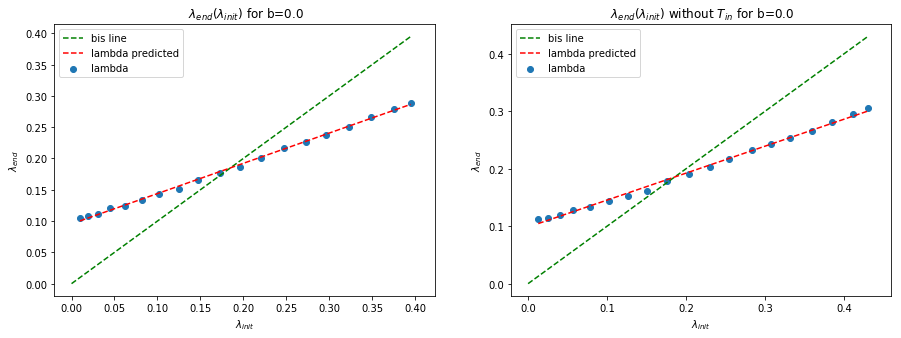

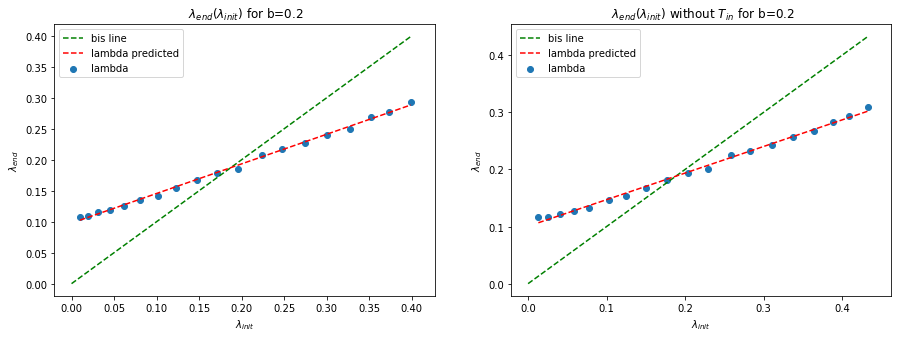

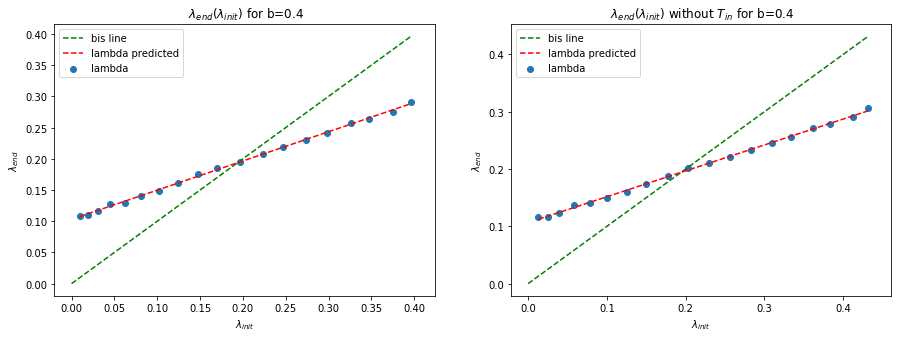

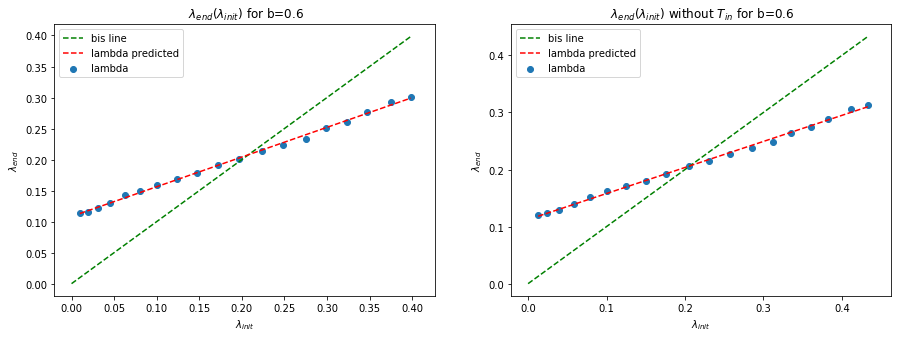

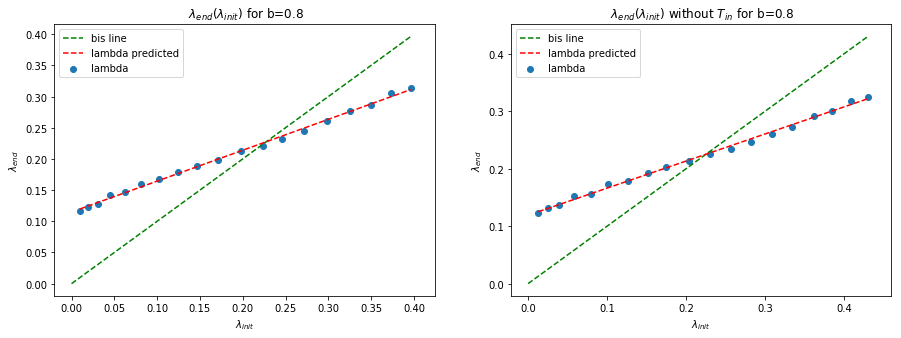

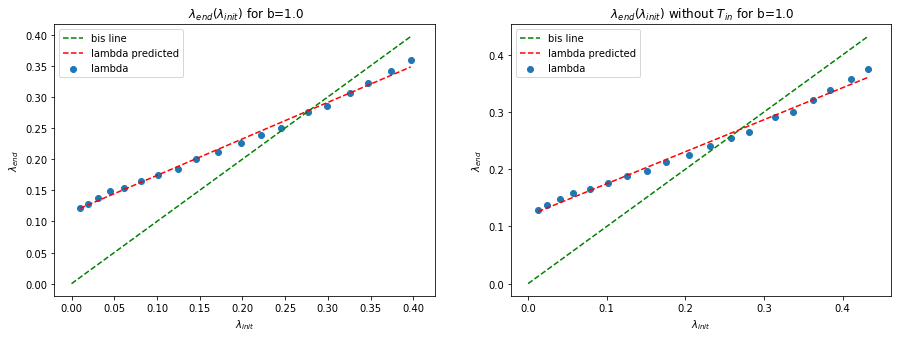

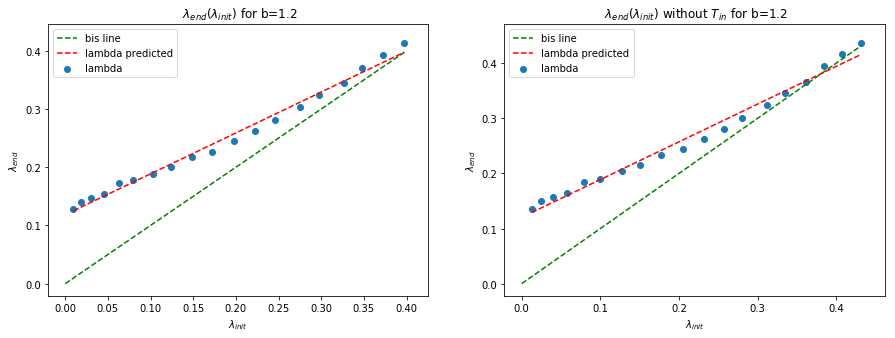

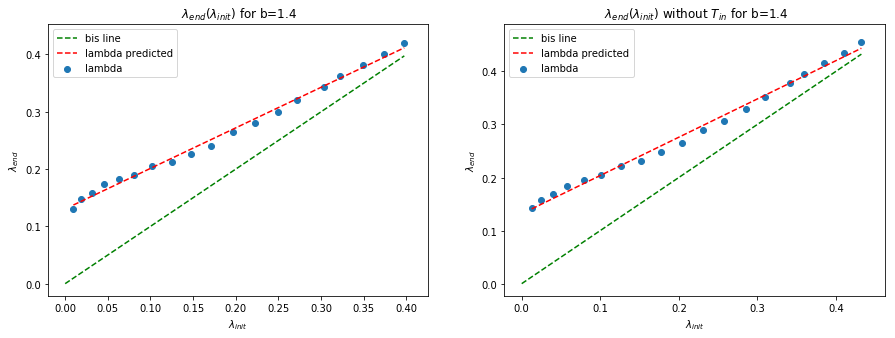

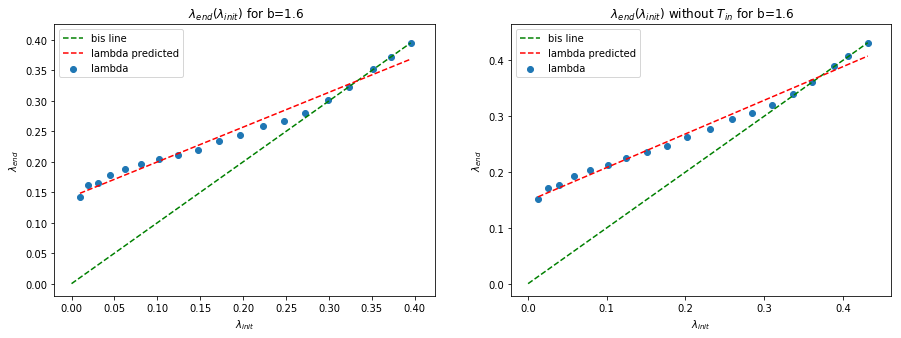

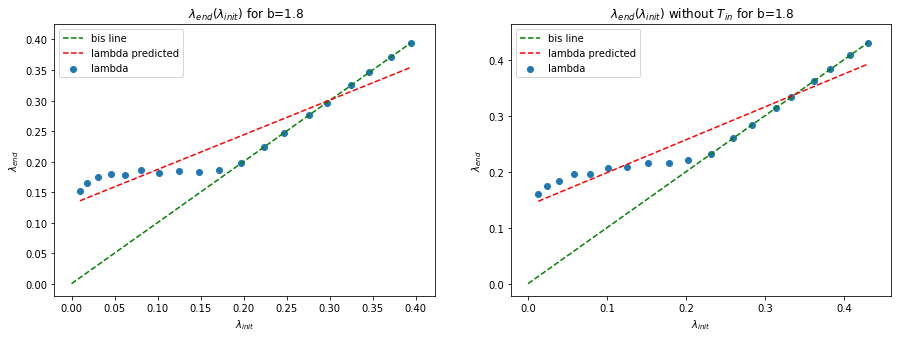

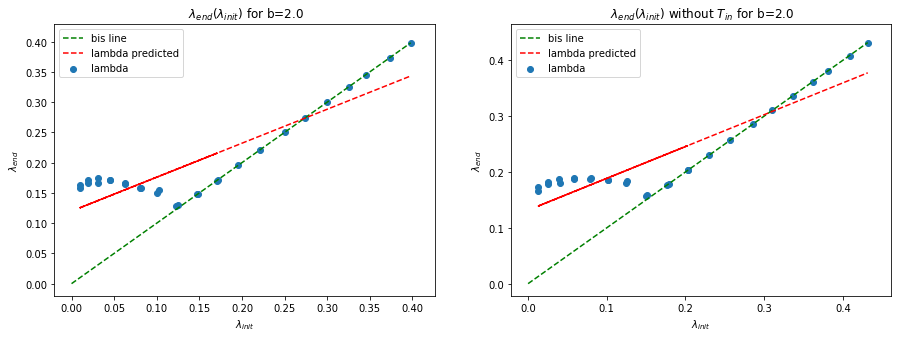

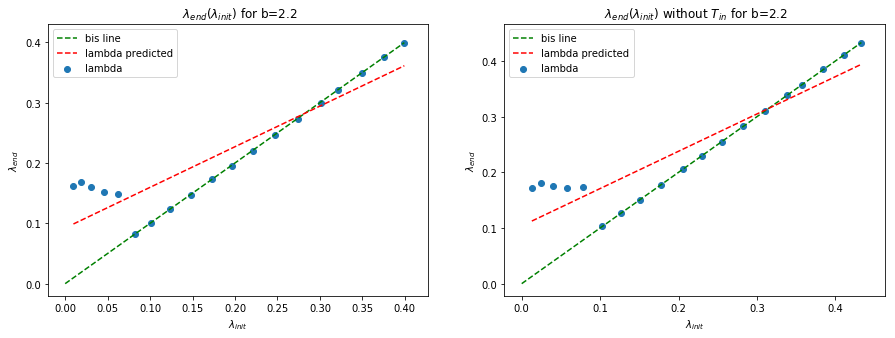

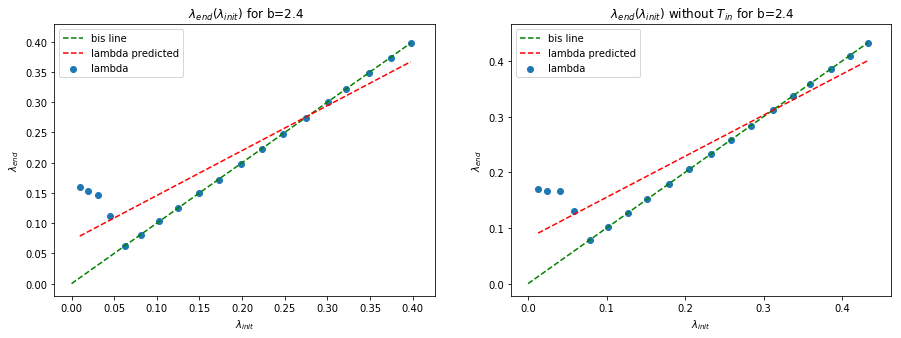

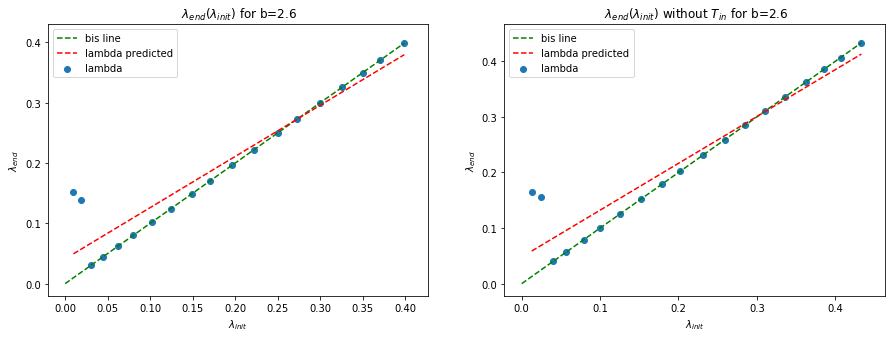

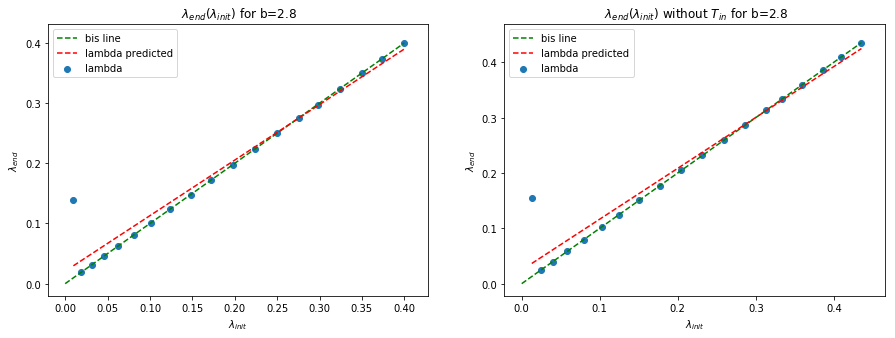

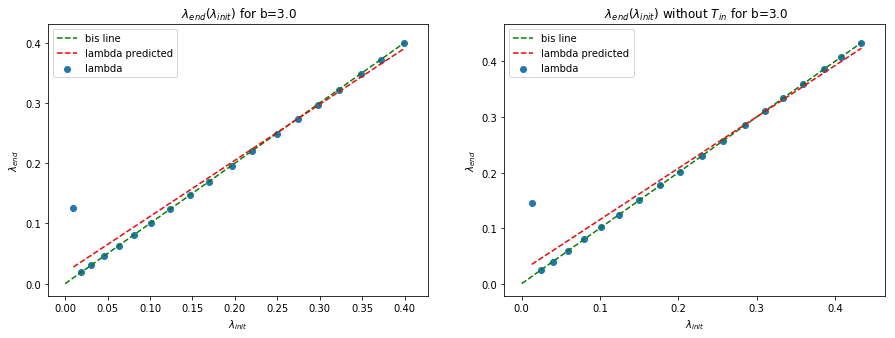

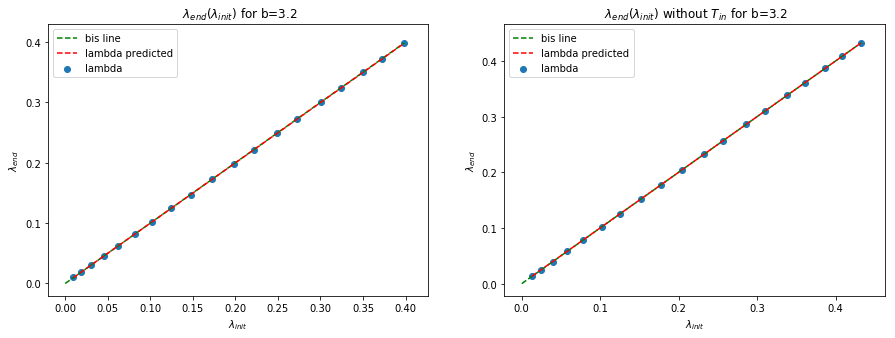

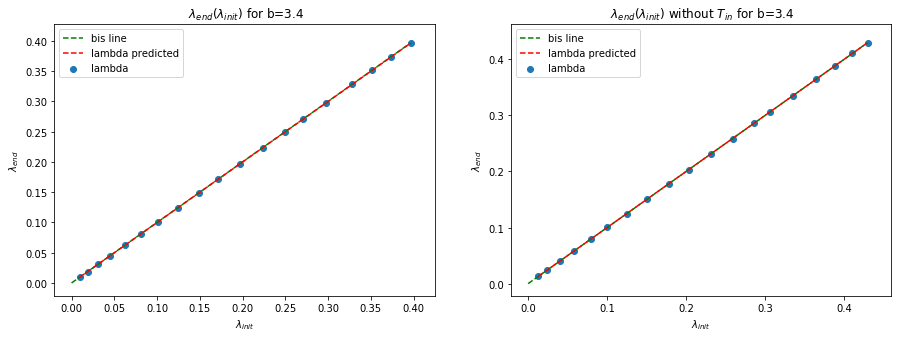

In [10]:
tg_alpha = []
lambda_eq = []
for b in sorted(result_b.keys()):
    plt.figure(1, figsize=(15,5))
    plt.subplot(121)
    plt.scatter(result_b[b ]['l1'], result_b[b ]['l2'], label = "lambda")
    plt.plot([0. ,np.max(result_b[b ]['l1'])], [0. ,np.max(result_b[b ]['l1'])], "g--",label = "bis line")
    
    fit = np.polyfit(result_b[b]['l1'],result_b[b]['l2'],1)
    fit_fn = np.poly1d(fit) 
    plt.plot(result_b[b]['l1'], fit_fn(result_b[b]['l1']), 'r--', label = "lambda predicted")
    
    # подсчёт параметров
    tg_alpha.append(fit[0])
    lambda_eq.append(fit[1]/(1-fit[0]))
    
    plt.xlabel('$\lambda_{init}$')
    plt.ylabel('$\lambda_{end}$')    
    plt.legend()
    plt.title(' $\lambda_{end}(\lambda_{init})$ for b=%s'%(b))
    
    plt.subplot(122)
    plt.scatter(result_b[b ]['l1_t'], result_b[b ]['l2_t'], label = "lambda")
    plt.plot([0. ,np.max(result_b[b ]['l1_t'])], [0. ,np.max(result_b[b ]['l1_t'])], "g--", label = "bis line")
    
    fit = np.polyfit(result_b[b]['l1_t'],result_b[b]['l2_t'],1)
    fit_fn = np.poly1d(fit) 
    plt.plot(result_b[b]['l1_t'], fit_fn(result_b[b]['l1_t']), 'r--', label = "lambda predicted")
    
    plt.xlabel('$\lambda_{init}$')
    plt.ylabel('$\lambda_{end}$')    
    plt.title(' $\lambda_{end}(\lambda_{init})$ without $T_{in}$ for b=%s'%(b))
    plt.legend()
    plt.show()


### Выводы:
    1. Оба способа показали схожие результаты.
    2. Равновесного числа 1/3 не получилось.

# Углы и равновесные $\lambda$ от прицельного расстояния

In [11]:
x = []
for i in (sorted(result_b.keys())):
    x.append(float(i))

Text(0,0.5,u'tg(alpha)')

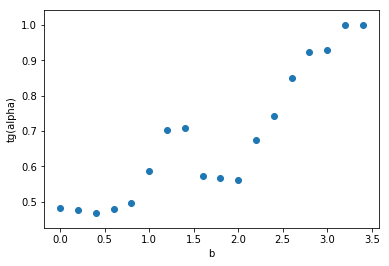

In [12]:
plt.scatter(x, tg_alpha)
plt.xlabel("b")
plt.ylabel("tg(alpha)")

### посмотрим $\lambda$ равновесное

Text(0,0.5,u'lambda eq')

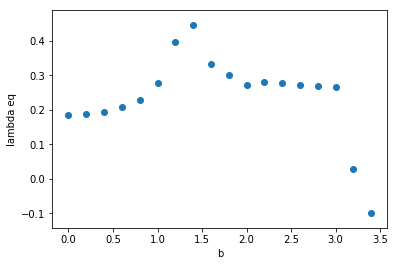

In [13]:
plt.scatter(x, lambda_eq)
plt.xlabel("b")
plt.ylabel("lambda eq")

Если не учитывать 3 последних явно нелинейных $\lambda$, то получим среднее зачнение 

In [22]:
np.mean(lambda_eq[0:9])

0.27297113377064397

Заметно, что оно почти получилось 2/7.

### Вывод:
Можно предположить квадратичную зависимость для $\lambda$ равновесного от b, не появляются такие $c_r$, при которых молекулы перестают замечать друг друга.

## Таблица зависимости

In [15]:
df = pd.DataFrame(columns=['b', 'tg alpha', 'lambda eq'])
for i in range(len(x)):
    df.loc[i] = [x[i], tg_alpha[i], lambda_eq[i]]
    
df

,b,tg alpha,lambda eq
0,0.0,0.483468,0.184940
1,0.2,0.477861,0.187250
2,0.4,0.467870,0.193569
3,0.6,0.478754,0.207855
4,0.8,0.495270,0.227592
5,1.0,0.586769,0.278748
6,1.2,0.702531,0.397753
7,1.4,0.707639,0.446101
8,1.6,0.571268,0.332933
9,1.8,0.568117,0.301483


# Проинтегрируем $\lambda$  по прицельному расстоянию

In [16]:
lmbd1, lmbd2 = [],[]
for v in sorted(result_v.keys()):
    lmbd1.append(np.sum(result_v[v]['T1'])/np.sum(result_v[v]['H1']))
    lmbd2.append(np.sum(result_v[v]['T2'])/np.sum(result_v[v]['H2']))

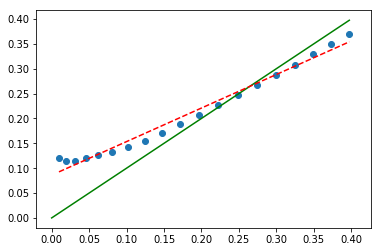

In [17]:
plt.scatter(lmbd1, lmbd2)
plt.plot([0,max(lmbd1)],[0,max(lmbd1)], 'g-')
fit = np.polyfit(lmbd1,lmbd2,1)
fit_fn = np.poly1d(fit) 
plt.plot(lmbd1, fit_fn(lmbd1), 'r--', label = "lambda predicted")

In [18]:
k = fit[0]
b = fit[1]
print b/(1-k)

0.26424297370013594


### Вывод:
Полученный $\lambda$ ближе к 2/7, чем к 1/3